# Evaluation of CosmoFlow training

This notebook shows how to evaluate the results of training one model.
It will plot the learning curves and do some evaluation on the test set, and finally will make some plots of prediction vs. truth.

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/benchmarks/cosmoflow-benchmark/notebooks'

In [2]:
import os
import sys
import yaml
import pickle

sys.path.append('..')

In [3]:
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from models import get_model
from data.cosmo import construct_dataset
from utils.optimizers import get_optimizer

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({'font.size': 14})

## Load the results

In [7]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_history(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

In [8]:
ls /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results

alt-cosmoflow-2020-03-05/  cosmoflow-2020-03-18/
cgpu-2020-06-28-n64/       cosmoflow-2020-03-19/
cgpu-2020-06-30-n64/       cosmoflow-2020-03-20/
cgpu-2020-07-02-n64/       cosmoflow-2020-03-23-n256/
cgpu-2020-07-03-n64/       cosmoflow-2020-03-23-n512/
cgpu-2020-07-04-n64/       cosmoflow-2020-03-23-n64/
cgpu-2020-07-07-n64-b128/  cosmoflow-2020-03-27/
cgpu-2020-07-09-n64-b128/  cosmoflow-2020-03-29/
cgpu-2020-07-14-n64-b128/  cosmoflow-2020-03-31/
cgpu-2020-07-16-n64-b128/  cosmoflow-2020-04-13-n64/
cgpu-2021-02-09-n64/       cosmoflow-2020-04-27-n128/
cgpu-amp-000/              cosmoflow-2020-04-28-n512/
cgpu-test-cscratch/        cosmoflow-2020-04-28-n512-noBB/
cgpu-tf2-000/              cosmoflow-2020-05-01-n128-gpu/
cori-2020-07-30-n1024-2/   cosmoflow-2020-05-01-n512/
cosmo-000/                 cosmoflow-2020-05-04-n1024/
cosmo2-2021-02-22-n16/     cosmoflow-2020-05-07-n1024/
cosmo2-bn-2021-03-04/      cosmoflow-2020-06-01-n1024-bb/
cosmo2-deep-2021-03-08/    cosmoflow-2020-06-

In [9]:
# Cori GPU, batch 64 baseline
result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-04-n64'

In [10]:
config = load_config(result_dir)
train_history = load_history(result_dir)

In [11]:
config

{'output_dir': '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-04-n64',
 'data': {'name': 'cosmo',
  'data_dir': '/tmp/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf',
  'n_train': 262144,
  'n_valid': 65536,
  'sample_shape': [128, 128, 128, 4],
  'batch_size': 1,
  'n_epochs': 128,
  'shard': True,
  'apply_log': True,
  'prefetch': 4,
  'staged_files': True},
 'model': {'name': 'cosmoflow',
  'input_shape': [128, 128, 128, 4],
  'target_size': 4,
  'conv_size': 32,
  'fc1_size': 128,
  'fc2_size': 64,
  'hidden_activation': 'LeakyReLU',
  'pooling_type': 'MaxPool3D',
  'dropout': 0.5},
 'optimizer': {'name': 'SGD', 'momentum': 0.9},
 'lr_schedule': {'base_lr': 0.001,
  'scaling': 'linear',
  'base_batch_size': 64,
  'n_warmup_epochs': 4,
  'decay_schedule': {32: 0.25, 64: 0.125}},
 'train': {'loss': 'mse', 'metrics': ['mae'], 'early_stopping_patience': 8},
 'n_ranks': 64}

## View training history

In [12]:
train_history

,epoch,loss,lr,mean_absolute_error,time,val_loss,val_mean_absolute_error
0,0,0.197874,0.001000,0.360728,363.243572,0.149902,0.306632
1,1,0.142357,0.001000,0.301646,311.127560,0.105883,0.261877
2,2,0.105506,0.001000,0.256934,305.786357,0.069577,0.206597
3,3,0.093842,0.001000,0.240385,303.267382,0.084966,0.234172
4,4,0.087407,0.001000,0.230974,303.999074,0.062700,0.187141
...,...,...,...,...,...,...,...
123,123,0.044614,0.000125,0.163419,308.755232,0.030303,0.121788
124,124,0.044697,0.000125,0.163602,309.087246,0.029144,0.119572
125,125,0.044456,0.000125,0.163172,308.281458,0.029656,0.121972
126,126,0.044452,0.000125,0.163279,305.794894,0.029215,0.119788


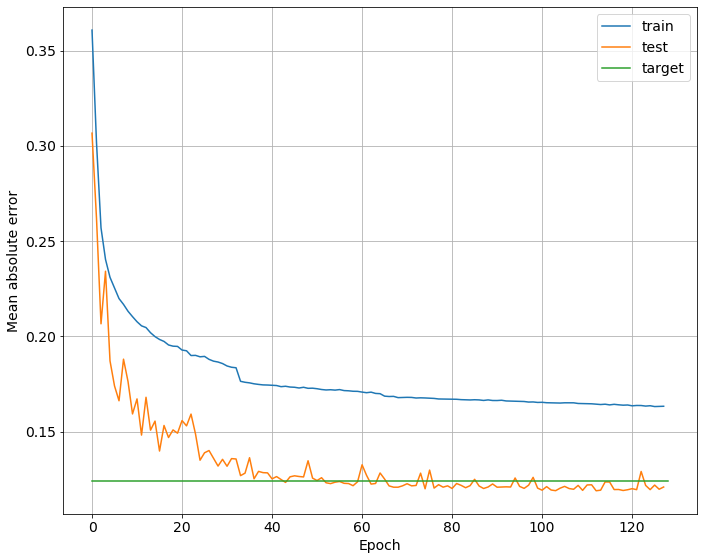

In [14]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 8))

ax1.plot(train_history.mean_absolute_error, label='train')
ax1.plot(train_history.val_mean_absolute_error, label='test')

# Draw targets
ax1.plot([0, len(train_history)], [0.124, 0.124], label='target')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean absolute error')
ax1.legend(loc=0)
ax1.grid()

plt.tight_layout()

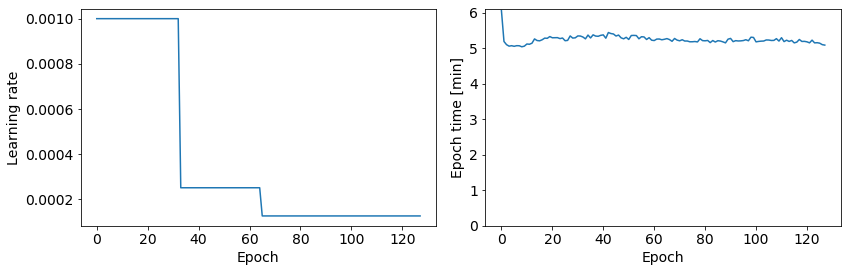

In [15]:
# Additional plots
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,4))

# Plot the learning rate
ax0.plot(train_history.lr)
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Learning rate')

ax1.plot(train_history.time/60)
ax1.set_ylim(bottom=0)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Epoch time [min]')

plt.tight_layout()

In [16]:
# Choose best epoch based on validation loss
best_epoch = train_history.epoch.loc[train_history.val_loss.idxmin()]
time_to_best = train_history.time.loc[:best_epoch].sum() / 60. / 60.
print(f'Best epoch {best_epoch} after {time_to_best:.2f} hours')

train_history.loc[[best_epoch]]

Best epoch 112 after 9.88 hours


,epoch,loss,lr,mean_absolute_error,time,val_loss,val_mean_absolute_error
112,112,0.045129,0.000125,0.164406,313.306366,0.02883,0.118983


## Reload the model

In [17]:
import models.cosmoflow

# Load the model checkpoint
checkpoint = os.path.join(result_dir, 'checkpoint-{epoch:03d}.h5'.format(epoch=best_epoch+1))
model = tf.keras.models.load_model(checkpoint)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 128, 128, 128, 32) 1056      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 128, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 64, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 64, 64)    16448     
_________________________________________________________________
lea

## Evaluate the model on a test set

In [18]:
def convert_data_to_np(dataset, n_steps):
    iter_next = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        converted_data = [sess.run(iter_next) for i in range(n_steps)]
        return map(np.concatenate, zip(*converted_data))

def convert_labels_to_np(dataset, n_steps):
    iter_next = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        return np.concatenate([sess.run(iter_next)[1] for i in range(n_steps)])

In [19]:
n_test = 8192
data_config = config['data']
batch_size = 8
data_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf/test'

In [20]:
data_config

{'name': 'cosmo',
 'data_dir': '/tmp/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf',
 'n_train': 262144,
 'n_valid': 65536,
 'sample_shape': [128, 128, 128, 4],
 'batch_size': 1,
 'n_epochs': 128,
 'shard': True,
 'apply_log': True,
 'prefetch': 4,
 'staged_files': True}

In [21]:
# Construct the test dataset
test_data, n_test_steps = construct_dataset(data_dir, n_samples=n_test, batch_size=batch_size,
                                            n_epochs=1, sample_shape=data_config['sample_shape'],
                                            apply_log=data_config.get('apply_log', False),
                                            randomize_files=True)

In [22]:
%%time

# Apply the model to the test set
test_pred = model.predict(test_data, steps=n_test_steps, verbose=1)

1024/1024 [==============================] - 939s 917ms/step
CPU times: user 8min 47s, sys: 3min 36s, total: 12min 24s
Wall time: 15min 38s


In [23]:
%%time

# Pull out the test dataset labels - this is slow!
test_y = convert_labels_to_np(test_data, n_test_steps)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
CPU times: user 7min 59s, sys: 3min 53s, total: 11min 52s
Wall time: 14min 46s


In [24]:
# Compute test set metrics
test_mse = sklearn.metrics.mean_squared_error(test_y, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(test_y, test_pred)

In [25]:
print('Test set results for %i samples and %i variables:' % test_pred.shape)
print('MSE:', test_mse)
print('MAE:', test_mae)

Test set results for 8192 samples and 4 variables:
MSE: 0.02879409
MAE: 0.11810121


## Model analysis

Let's make some detailed plots to understand the performance of the model

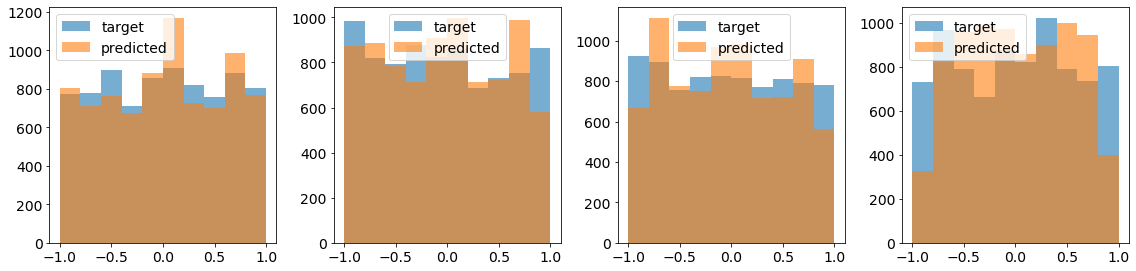

In [26]:
# 1D Distributions of cosmo params
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16, 4))

hist_args = dict(bins=10, range=(-1,1), alpha=0.6)
ax0.hist(test_y[:,0], label='target', **hist_args)
ax0.hist(test_pred[:,0], label='predicted', **hist_args)
ax0.legend(loc=0)
ax1.hist(test_y[:,1], label='target', **hist_args)
ax1.hist(test_pred[:,1], label='predicted', **hist_args)
ax1.legend(loc=0)
ax2.hist(test_y[:,2], label='target', **hist_args)
ax2.hist(test_pred[:,2], label='predicted', **hist_args)
ax2.legend(loc=0)
ax3.hist(test_y[:,3], label='target', **hist_args)
ax3.hist(test_pred[:,3], label='predicted', **hist_args)
ax3.legend(loc=0)
plt.tight_layout()

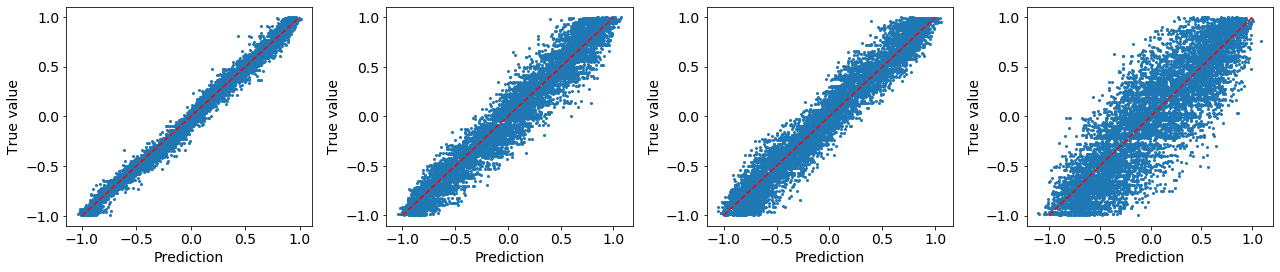

In [27]:
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))

for i, ax in enumerate(axs):
    ax.scatter(test_pred[:,i], test_y[:,i], s=4)
    ax.plot([-1, 1], [-1, 1], 'r--')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True value')

plt.tight_layout()

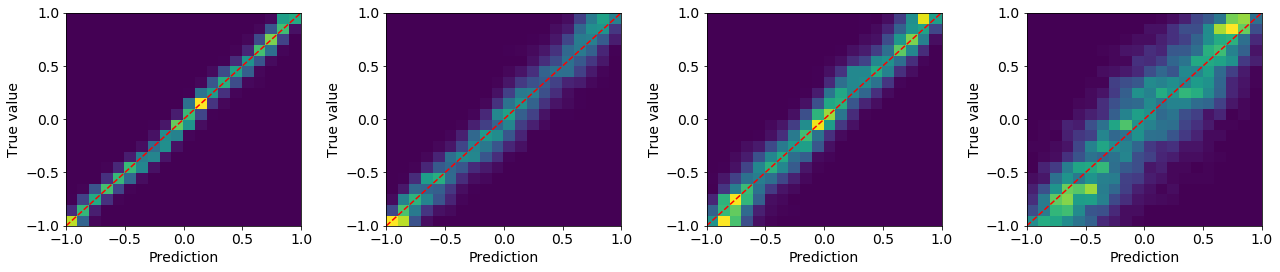

In [28]:
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))

for i, ax in enumerate(axs):
    ax.hist2d(test_pred[:,i], test_y[:,i], bins=20, range=[[-1,1],[-1,1]])
    ax.plot([-1, 1], [-1, 1], 'r--')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True value')

plt.tight_layout()

## Discussion

The model is converging nicely at this scale with this dataset.
We still need to push it further and tune the hyperparameters for larger scale runs.